In [102]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

In [64]:
confound = pd.read_csv('/data100/dataset/ds000113/derivatives/fmriprep_241016/sub-01/ses-movie/func/sub-01_ses-movie_task-movie_run-2_desc-confounds_timeseries.tsv',sep = '\t')

In [65]:
confound['framewise_displacement']

0           NaN
1      0.061553
2      0.057106
3      0.078179
4      0.046576
         ...   
436    0.084490
437    0.083224
438    0.095525
439    0.090753
440    0.079168
Name: framewise_displacement, Length: 441, dtype: float64

In [66]:
import os
import pandas as pd

data_dir = '/data100/dataset/ds000113/derivatives/fmriprep_241016/'
excluded_files_path = 'excluded_files.txt'
excluded_files = []
for root, dirs, files in os.walk(data_dir):
    dirs[:] = [d for d in dirs if d == 'ses-movie']
    for file in files:
        if file.endswith('.nii.gz') and '_space-MNI152NLin6Asym_desc-preproc_bold' in file:
            nii_file_path = os.path.join(root, file)
            confounds_file = file.replace('_space-MNI152NLin6Asym_desc-preproc_bold.nii.gz', '_desc-confounds_timeseries.tsv')
            confounds_path = os.path.join(root, confounds_file)
            if os.path.exists(confounds_path):
                confounds_df = pd.read_csv(confounds_path, sep='\t')
                if 'framewise_displacement' in confounds_df.columns:
                    fd_series = confounds_df['framewise_displacement'].dropna()
                    mean_fd = fd_series.mean()
                    max_fd = fd_series.max()
                    if mean_fd > 0.3 or max_fd > 10:
                        print(nii_file_path, mean_fd, max_fd)
                        excluded_files.append((nii_file_path, mean_fd, max_fd))

### 按照平均fd大于0.3或fd大于10的标准没有需要排除的，接下来进一步可视化数据

In [68]:
excluded_files

[]

In [81]:
def plot_all_runs_fd(data_dir):
   all_data = []
   
   # 遍历所有confounds文件
   for conf_file in Path(data_dir).rglob("*_desc-confounds_timeseries.tsv"):
       if 'ses-movie' not in str(conf_file):
           continue
       sub = conf_file.parts[-4]
       
       # 提取run信息
       file_parts = conf_file.name.split('_')
       run_part = [part for part in file_parts if 'run-' in part]
       if not run_part:
           continue
       run = run_part[0]
       run_num = int(run.split('-')[1])
       
       # read FD
       df = pd.read_csv(conf_file, sep='\t')
       if 'framewise_displacement' in df.columns:
           fd = df['framewise_displacement'].dropna()
           all_data.extend([(sub, run, run_num, val) for val in fd])

   fd_df = pd.DataFrame(all_data, columns=['Subject', 'Run', 'Run_num', 'FD'])
   fd_df = fd_df.sort_values(['Subject', 'Run_num'])

   plt.figure(figsize=(15, 6))
   sns.violinplot(data=fd_df, x='Run', y='FD', 
                 palette='rocket', cut=0,
                 order=sorted(fd_df['Run'].unique()))
   
   plt.axhline(y=0.3, color='r', linestyle='--', alpha=0.5)
   plt.title('3T Audio Movie Data: FD Distribution by Run')
   plt.xlabel('Run')
   plt.ylabel('Framewise displacement (mm)')
   plt.xticks(rotation=45)
   plt.tight_layout()
   plt.show()

In [82]:
def plot_all_subjects_fd(data_dir):
   all_data = []
   
   # 遍历所有confounds文件
   for conf_file in Path(data_dir).rglob("*_desc-confounds_timeseries.tsv"):
       if 'ses-movie' not in str(conf_file):
           continue
       sub = conf_file.parts[-4]  
       sub_num = int(sub.split('-')[1])
       
       # read FD
       df = pd.read_csv(conf_file, sep='\t')
       if 'framewise_displacement' in df.columns:
           fd = df['framewise_displacement'].dropna()
           all_data.extend([(sub, sub_num, val) for val in fd])
   
   fd_df = pd.DataFrame(all_data, columns=['Subject', 'Subject_num', 'FD'])
   fd_df = fd_df.sort_values('Subject_num')

   plt.figure(figsize=(15, 6))
   sns.violinplot(data=fd_df, x='Subject', y='FD', 
                 palette='rocket', cut=0,
                 order=fd_df.groupby('Subject').first().reset_index()['Subject'])
   
   plt.axhline(y=0.3, color='r', linestyle='--', alpha=0.5)

   plt.title('3T Audio Movie Data: FD Distribution by Subject')
   plt.xlabel('Subject')
   plt.ylabel('Framewise displacement (mm)')
   plt.xticks(rotation=45)
   plt.tight_layout()
   plt.show()

In [78]:
def plot_single_subject_fd(data_dir, subject_id='sub-20'):
    """为单个被试的所有run绘制头动分布图"""
    all_data = []
    
    # 遍历指定被试的confounds文件
    subject_files = list(Path(data_dir).rglob(f"{subject_id}/*/*/*_desc-confounds_timeseries.tsv"))
    
    if not subject_files:
        print(f"No data found for {subject_id}")
        return
        
    for conf_file in subject_files:
        if 'ses-movie' not in str(conf_file):
            continue
            
        # 从文件名中提取run信息
        file_parts = conf_file.name.split('_')
        run_part = [part for part in file_parts if 'run-' in part]
        if not run_part:
            continue
        run = run_part[0]
        run_num = int(run.split('-')[1])
        
        # read FD
        df = pd.read_csv(conf_file, sep='\t')
        if 'framewise_displacement' in df.columns:
            fd = df['framewise_displacement'].dropna()
            if not fd.empty:
                all_data.extend([(run, run_num, val) for val in fd])
    
    if not all_data:
        print(f"No valid FD data found for {subject_id}")
        return
        
    fd_df = pd.DataFrame(all_data, columns=['Run', 'Run_num', 'FD'])
    fd_df = fd_df.sort_values('Run_num')

    plt.figure(figsize=(15, 6))
    sns.violinplot(data=fd_df, x='Run', y='FD', 
                  palette='rocket', cut=0,
                  order=fd_df.groupby('Run').first().reset_index()['Run'])
    
    plt.axhline(y=0.3, color='r', linestyle='--', alpha=0.5)
    plt.title(f'3T Audio Movie Data: FD Distribution for {subject_id}')
    plt.xlabel('Run')
    plt.ylabel('Framewise displacement (mm)')
    plt.tight_layout()
    plt.show()

In [91]:
def plot_single_run_fd(data_dir, run_id='run-1'):
    """为单个run的所有被试绘制头动分布图"""
    all_data = []
    
    # 遍历所有confounds文件
    for conf_file in Path(data_dir).rglob(f"*/*/*_desc-confounds_timeseries.tsv"):
        if 'ses-movie' not in str(conf_file):
            continue
            
        # 检查是否是指定的run
        if run_id not in str(conf_file):
            continue
            
        # 提取subject信息
        sub = conf_file.parts[-4]  # 获取sub-XX
        sub_num = int(sub.split('-')[1])
        
        # read FD
        df = pd.read_csv(conf_file, sep='\t')
        if 'framewise_displacement' in df.columns:
            fd = df['framewise_displacement'].dropna()
            if not fd.empty:
                all_data.extend([(sub, sub_num, val) for val in fd])
    
    if not all_data:
        print(f"No valid FD data found for {run_id}")
        return
        
    fd_df = pd.DataFrame(all_data, columns=['Subject', 'Subject_num', 'FD'])
    fd_df = fd_df.sort_values('Subject_num')

    plt.figure(figsize=(15, 6))
    sns.violinplot(data=fd_df, x='Subject', y='FD', 
                  palette='rocket', cut=0,
                  order=fd_df.groupby('Subject').first().reset_index()['Subject'])
    
    plt.axhline(y=0.3, color='r', linestyle='--', alpha=0.5)
    plt.text(-0.5, 0.31, 'FD = 0.3 mm', color='r', alpha=0.7)
    plt.title(f'3T Audio Movie Data: FD Distribution for {run_id}')
    plt.xlabel('Subject')
    plt.ylabel('Framewise displacement (mm)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

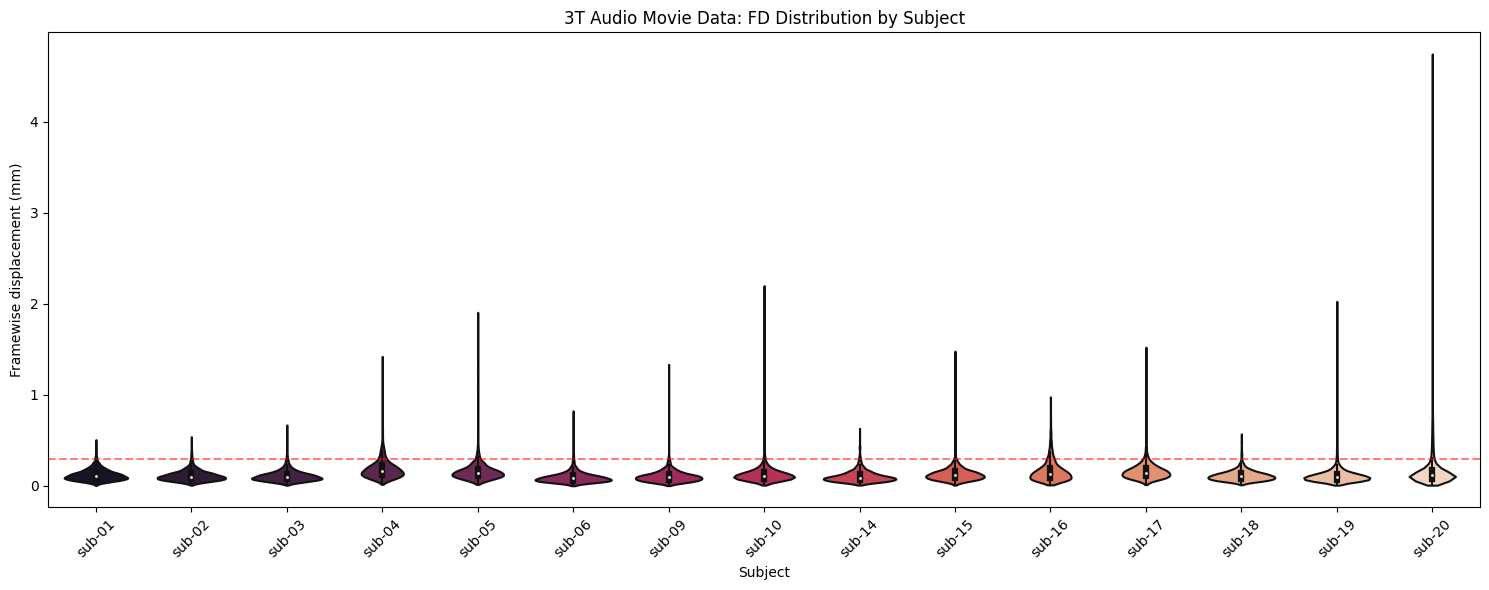

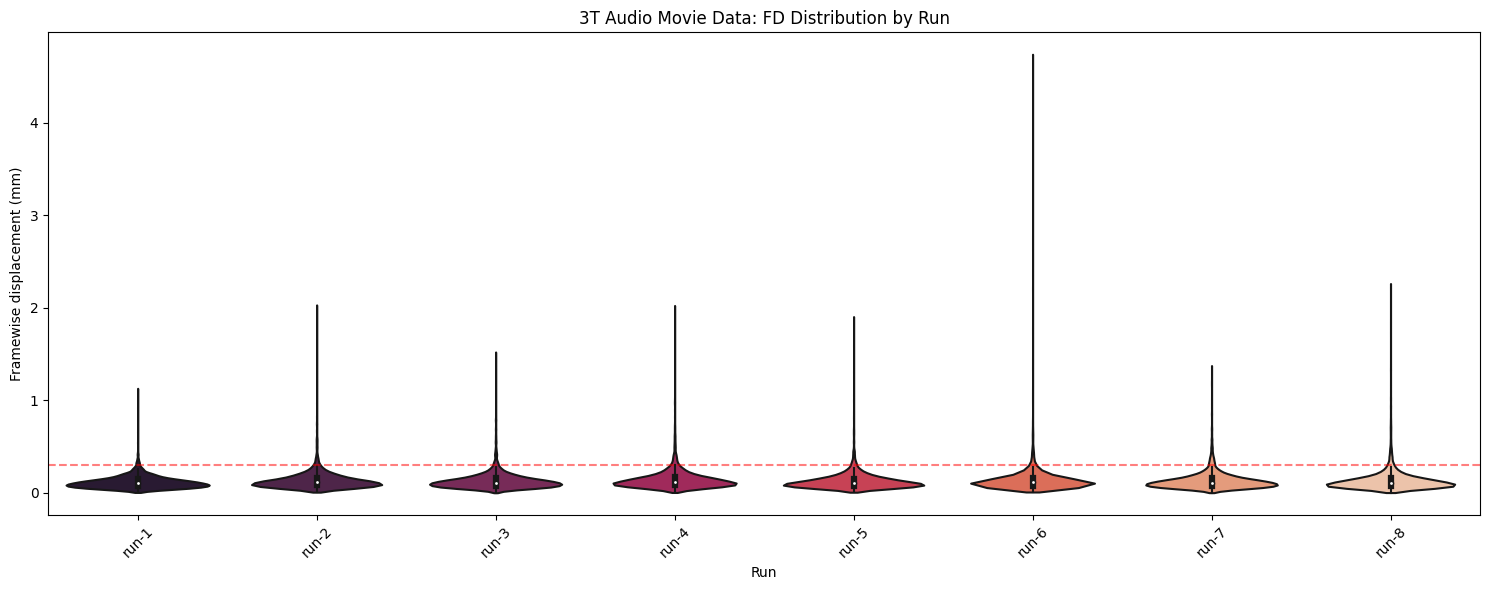

In [83]:
data_dir = '/data100/dataset/ds000113/derivatives/fmriprep_241016/'
plot_all_subjects_fd(data_dir)
plot_all_runs_fd(data_dir)

### 通过这种可视化方式，发现sub-20的run-6应该是一个显著的outlier

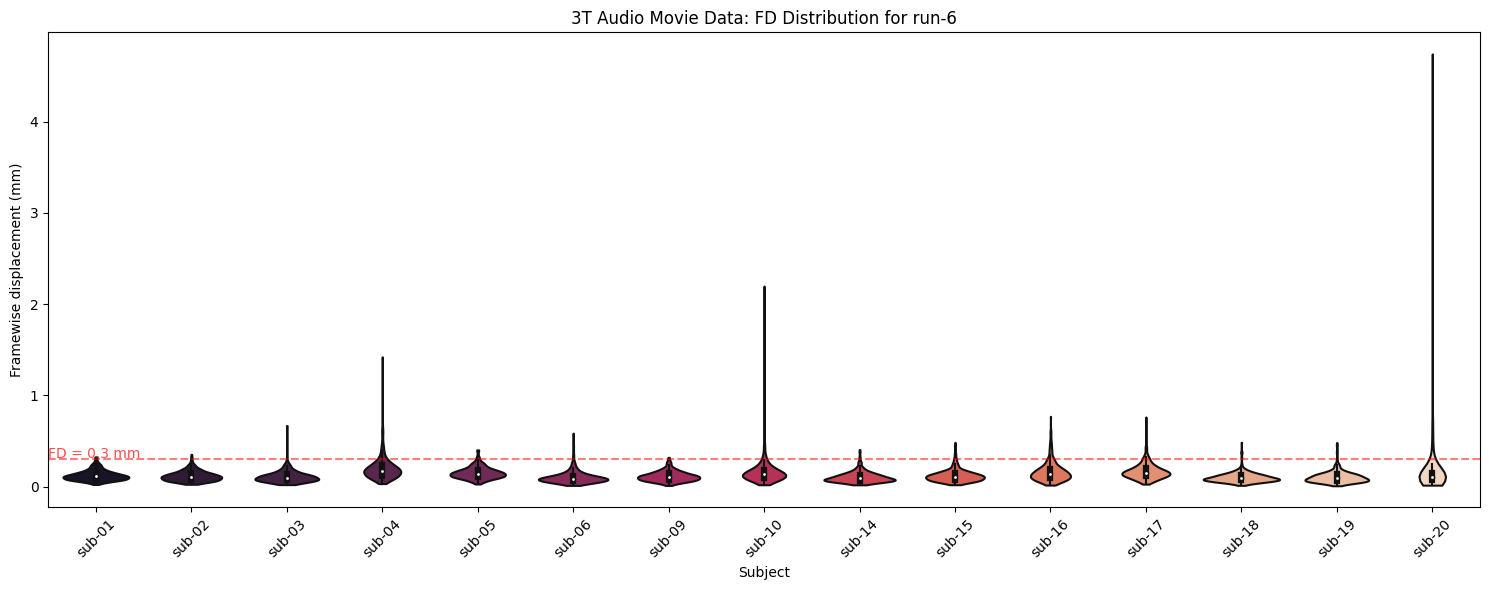

In [98]:
plot_single_run_fd(data_dir, 'run-6')

In [118]:
def plot_fd_clusters(data_dir):
    """绘制FD的簇状柱形图：8个run位置（簇间有间隙），每个run位置显示所有被试的柱子"""
    all_data = []
    
    # 遍历所有confounds文件获取数据
    for conf_file in Path(data_dir).rglob("*/*/*_desc-confounds_timeseries.tsv"):
        if 'ses-movie' not in str(conf_file):
            continue
            
        # 获取run信息
        if 'run-' not in str(conf_file):
            continue
        run_num = int(str(conf_file).split('run-')[1].split('_')[0])
        
        # 获取subject信息
        sub = conf_file.parts[-4]
        sub_num = int(sub.split('-')[1])
        
        # 读取FD数据
        df = pd.read_csv(conf_file, sep='\t')
        if 'framewise_displacement' in df.columns:
            fd = df['framewise_displacement'].dropna()
            if not fd.empty:
                mean_fd = fd.mean()
                all_data.append((run_num, sub_num, mean_fd))
    
    # 转换为DataFrame并获取唯一的被试编号
    df = pd.DataFrame(all_data, columns=['Run', 'Subject', 'Mean_FD'])
    unique_subjects = sorted(df['Subject'].unique())
    num_subjects = len(unique_subjects)
    
    print(f"Found {num_subjects} subjects: {unique_subjects}")
    
    # 创建图形
    plt.figure(figsize=(20, 8))
    
    # 设置柱子参数
    bar_width = 0.08  # 柱子宽度
    cluster_gap = 0.8  # run之间的间隙
    opacity = 0.8
    colors = plt.cm.Set3(np.linspace(0, 1, num_subjects))
    
    # 为每个run创建一个中心位置（添加间隙）
    run_positions = np.arange(8) * (1 + cluster_gap)  # 增加run之间的距离
    
    # 为每个被试在每个run位置画柱子
    for i, subject in enumerate(unique_subjects):
        # 计算这个被试的柱子位置：run位置加上偏移
        x = run_positions + (i - num_subjects/2) * bar_width  # 柱子紧密排列
        
        # 获取这个被试在每个run的数据
        heights = []
        for run in range(1, 9):  # 8个run
            run_data = df[(df['Run'] == run) & (df['Subject'] == subject)]
            if not run_data.empty:
                heights.append(run_data.iloc[0]['Mean_FD'])
            else:
                heights.append(0)
        
        plt.bar(x, heights, 
               bar_width, 
               alpha=opacity,
               color=colors[i],
               label=f'Sub-{subject:02d}')
    
    # 添加参考线
    plt.axhline(y=0.3, color='r', linestyle='--', alpha=0.5)
    plt.text(run_positions[0], 0.31, 'FD = 0.3 mm', color='r', alpha=0.7)
    
    # 设置图表属性
    plt.xlabel('Run Number')
    plt.ylabel('Mean Framewise Displacement (mm)')
    plt.title('Mean FD Distribution by Run and Subject')
    
    # 设置x轴刻度
    plt.xticks(run_positions, [f'Run {i}' for i in range(1, 9)])
    
    # 添加图例
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()
    
    return df

Found 15 subjects: [1, 2, 3, 4, 5, 6, 9, 10, 14, 15, 16, 17, 18, 19, 20]


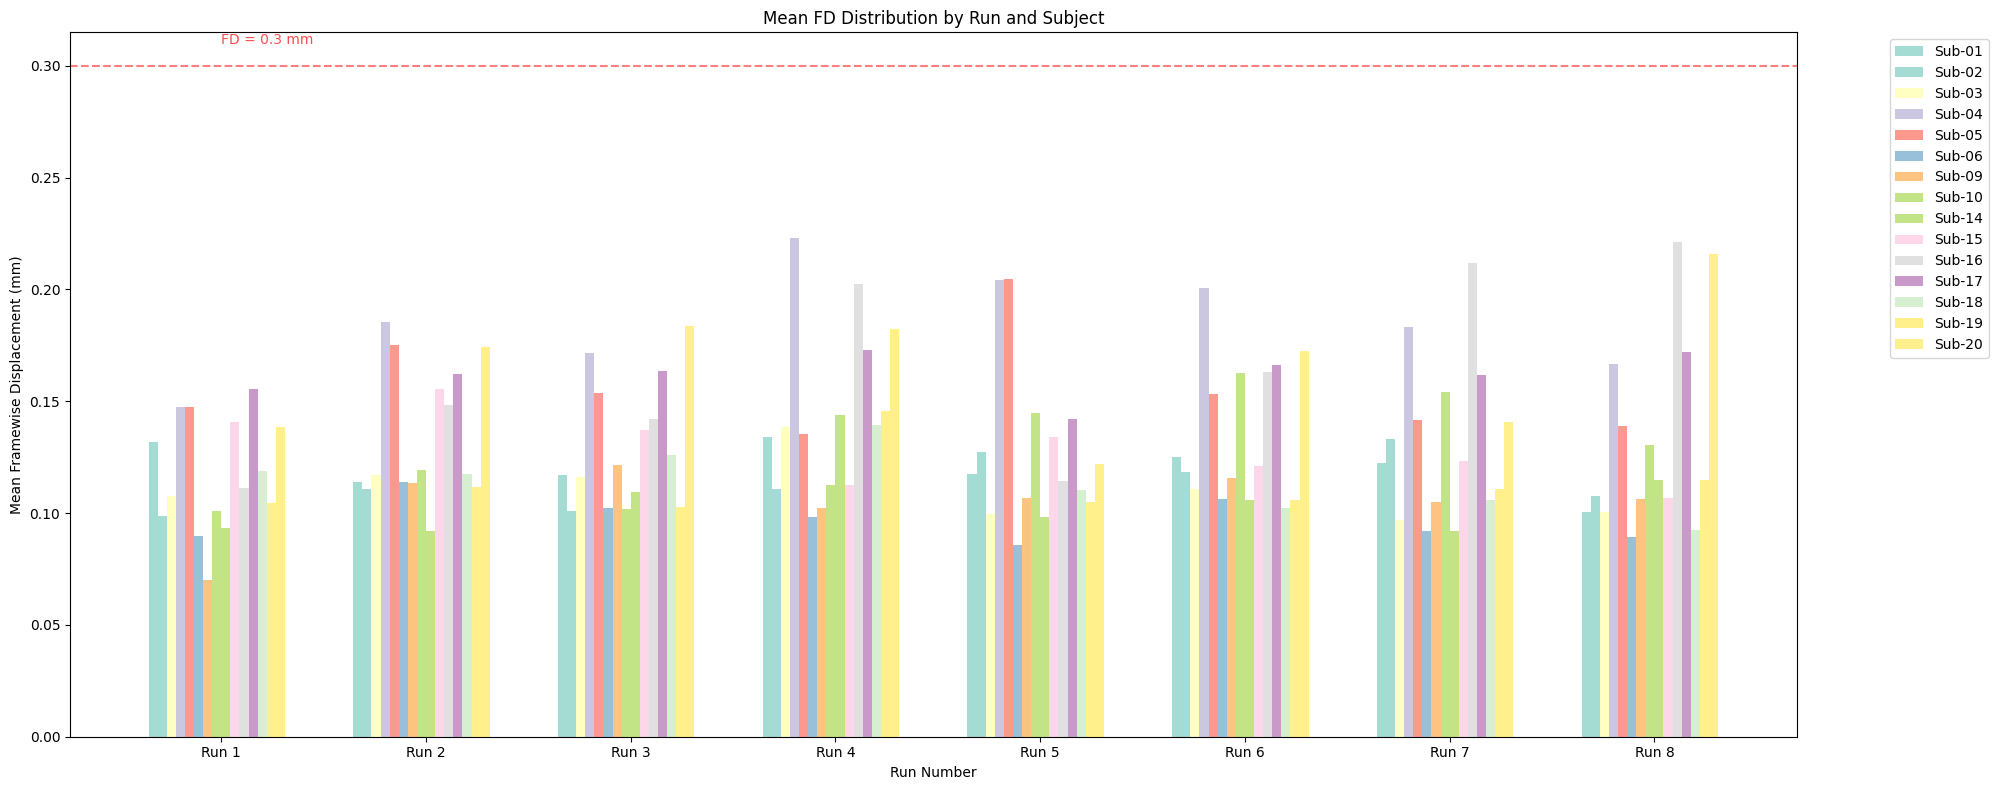

,Run,Subject,Mean_FD
0,7,3,0.097100
1,4,3,0.138555
2,6,3,0.110807
3,2,3,0.116920
4,1,3,0.107577
...,...,...,...
115,3,18,0.126023
116,8,18,0.092276
117,6,18,0.102145
118,4,18,0.139263


In [119]:
plot_fd_clusters(data_dir)